In [ ]:
import pandas as pd
import numpy as np
import sklearn
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
import optuna
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
InteractiveShell.ast_node_interactivity = "all"


df = pd.read_csv('preprocessed.csv')

In [147]:
X = df.drop(columns=['Customer Status'])
y = df['Customer Status']

X.shape

(6589, 16)

In [148]:
arg_dict = {
	'No':0,
	'Yes': 1
}

X['Multiple Lines'] = X['Multiple Lines'].map(arg_dict)
X['Internet Service'] = X['Internet Service'].map(arg_dict)
X = pd.concat([X, pd.get_dummies(X['Contract'], drop_first=True)], axis=1).drop(columns=['Contract'])
X['One Year'] = X['One Year'].astype('int32')
X['Two Year'] = X['Two Year'].astype('int32')
X['Married'] = X['Married'].map(arg_dict)
X['Phone Service'] = X['Phone Service'].map(arg_dict)
X['Paperless Billing'] = X['Paperless Billing'].map(arg_dict)
X = pd.concat([X, pd.get_dummies(X['Payment Method'], drop_first=True).astype('int32')], axis=1).drop(columns=['Payment Method'])
X = pd.concat([X, pd.get_dummies(X['Gender'], drop_first=True).astype('int32')], axis=1).drop(columns=['Gender'])
X.head()

,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Paperless Billing,Monthly Charge,Total Refunds,Total Extra Data Charges,One Year,Two Year,Credit Card,Mailed Check,Male
0,37,1,0,2,9,1,42.39,0,1,1,65.6,0.00,0,1,0,1,0,0
1,46,0,0,0,9,1,10.69,1,1,0,-4.0,38.33,10,0,0,1,0,1
2,50,0,0,0,4,1,33.65,0,1,1,73.9,0.00,0,0,0,0,0,1
3,78,1,0,1,13,1,27.82,0,1,1,98.0,0.00,0,0,0,0,0,1
4,75,1,0,3,3,1,7.38,0,1,1,83.9,0.00,0,0,0,1,0,0


In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
num_cols = pd.Index(['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Monthly Charge', 'Total Refunds', 'Total Extra Data Charges'])
cat_cols = pd.Index(['Married', 'Phone Service',  'Multiple Lines', 'Internet Service', 'Paperless Billing', 'One Year', 'Two Year', 'Credit Card', 'Mailed Check', 'Male'])


scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train_scaled = pd.concat([pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train.index), X_train[cat_cols]], axis=1)

X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index), X_test[cat_cols]], axis=1)

,copy,True
,with_mean,True
,with_std,True


In [150]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

print('ROC-AUC: ', np.round(roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]), 3))
print('PR-AUC: ', np.round(average_precision_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]), 3))
print()
print(classification_report(y_test, log_reg.predict(X_test_scaled)))

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


ROC-AUC:  0.905
PR-AUC:  0.778

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1181
           1       0.70      0.74      0.72       467

    accuracy                           0.84      1648
   macro avg       0.80      0.81      0.80      1648
weighted avg       0.84      0.84      0.84      1648



Попробуем подбором гиперпараметров улучшить baseline:


In [151]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("bin", "passthrough", cat_cols),          
        
    ],
    remainder="drop"
)

def objective_logreg(trial: optuna.trial):
	C = trial.suggest_float('C', 1e-3, 1e3, log=True)
	class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
	penalty = trial.suggest_categorical('penalty', ['l2'])

	model = Pipeline([
		('prep', preprocess),
		('clf', LogisticRegression(
			C=C,
			solver='lbfgs',
			penalty=penalty,
			class_weight=class_weight,
			max_iter=3000,
			random_state=42
		))
	])

	cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
	return cross_val_score(model, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective_logreg, n_trials=30)

[I 2025-12-29 14:12:35,214] A new study created in memory with name: no-name-7048c78d-f813-4ba1-939a-3962ede7d058
[I 2025-12-29 14:12:38,807] Trial 0 finished with value: 0.7623264397985158 and parameters: {'C': 0.0037066824622754117, 'class_weight': None, 'penalty': 'l2'}. Best is trial 0 with value: 0.7623264397985158.
[I 2025-12-29 14:12:41,496] Trial 1 finished with value: 0.7893560871926629 and parameters: {'C': 162.14915824012007, 'class_weight': None, 'penalty': 'l2'}. Best is trial 1 with value: 0.7893560871926629.
[I 2025-12-29 14:12:44,331] Trial 2 finished with value: 0.7893497310412113 and parameters: {'C': 38.33166436312645, 'class_weight': None, 'penalty': 'l2'}. Best is trial 1 with value: 0.7893560871926629.
[I 2025-12-29 14:12:47,106] Trial 3 finished with value: 0.7857733887782236 and parameters: {'C': 5.451543246258619, 'class_weight': 'balanced', 'penalty': 'l2'}. Best is trial 1 with value: 0.7893560871926629.
[I 2025-12-29 14:12:47,157] Trial 4 finished with value

In [152]:
log_reg_tuned = LogisticRegression(**study.best_params)

log_reg_tuned.fit(X_train_scaled, y_train)

print('Результаты LogisticRegression с подбором гиперпараметров:')
print('ROC-AUC: ', np.round(roc_auc_score(y_test, log_reg_tuned.predict_proba(X_test_scaled)[:, 1]), 3))
print('PR-AUC: ', np.round(average_precision_score(y_test, log_reg_tuned.predict_proba(X_test_scaled)[:, 1]), 3))
print()
print(classification_report(y_test, log_reg_tuned.predict(X_test_scaled)))

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.10871084197298703
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Результаты LogisticRegression с подбором гиперпараметров:
ROC-AUC:  0.905
PR-AUC:  0.784

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1181
           1       0.72      0.73      0.73       467

    accuracy                           0.84      1648
   macro avg       0.81      0.81      0.81      1648
weighted avg       0.84      0.84      0.84      1648



Особо улучшить модель не получилось с помощью подбора гиперпараметров

In [153]:
from sklearn.svm import SVC

params = [{
	'C': np.arange(0.01, 10.01, 0.25),
	'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
	'kernel': ['rbf', 'linear', 'sigmoid']
},
{
	'C': np.arange(0.01, 10.01, 0.25),
	'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
	'kernel': ['poly'],
	'degree': [3, 4, 5, 6]
}
]

def objective_svc(trial):
    C = trial.suggest_float("C", 0.01, 10.01)
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear", "sigmoid", "poly"])

    if kernel in ["rbf", "sigmoid", "poly"]:
        gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log=True)
    else:
        gamma = "scale"

    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
    else:
        degree = 3

    model = Pipeline([('prep', preprocess),
        ('model', SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, probability=False))
        ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="average_precision", n_jobs=-1).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective_svc, n_trials=70)

[I 2025-12-29 14:12:48,222] A new study created in memory with name: no-name-48a9f62e-add4-41b8-922d-7f46fad53282
[I 2025-12-29 14:12:48,635] Trial 0 finished with value: 0.7924166113512063 and parameters: {'C': 9.850228779201629, 'kernel': 'rbf', 'gamma': 0.0011913555913265661}. Best is trial 0 with value: 0.7924166113512063.
[I 2025-12-29 14:12:48,904] Trial 1 finished with value: 0.7380450271983477 and parameters: {'C': 9.591150177568156, 'kernel': 'poly', 'gamma': 0.007098137310433795, 'degree': 3}. Best is trial 0 with value: 0.7924166113512063.
[I 2025-12-29 14:12:49,345] Trial 2 finished with value: 0.7902229158624995 and parameters: {'C': 6.340392456794738, 'kernel': 'linear'}. Best is trial 0 with value: 0.7924166113512063.
[I 2025-12-29 14:12:49,837] Trial 3 finished with value: 0.7777082141923781 and parameters: {'C': 5.694354833260193, 'kernel': 'rbf', 'gamma': 0.000551484976851119}. Best is trial 0 with value: 0.7924166113512063.
[I 2025-12-29 14:12:50,379] Trial 4 finishe

In [154]:
model_SVC = SVC(**study.best_params)
model_SVC.fit(X_train_scaled, y_train)
y_score = model_SVC.decision_function(X_test_scaled)

print('Результаты SVC модели с подбором гиперпараметров:')
print('ROC-AUC: ', np.round(roc_auc_score(y_test, y_score), 3))
print('PR-AUC: ', np.round(average_precision_score(y_test, y_score), 3))
print()
print(classification_report(y_test, model_SVC.predict(X_test_scaled)))

,C,6.334862522426768
,kernel,'rbf'
,degree,3
,gamma,0.032447774859143436
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Результаты SVC модели с подбором гиперпараметров:
ROC-AUC:  0.911
PR-AUC:  0.81

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1181
           1       0.75      0.72      0.74       467

    accuracy                           0.85      1648
   macro avg       0.82      0.81      0.82      1648
weighted avg       0.85      0.85      0.85      1648



Модель SVC получилась лучше, чем baseline по ROC-AUC и PR-AUС, незначительно лучше по precision, recall и f1-score при базовом пороге 0.5 

In [155]:
from sklearn.ensemble import RandomForestClassifier


def objective_randforest(trial:optuna.Trial):
	n_estimators = trial.suggest_int('n_estimators', 10, 800)
	max_depth = trial.suggest_int('max_depth', 2, 20)
	max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
	criterion=trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
	min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
	min_samples_split = trial.suggest_int('min_samples_split', 2, 100)

	score = cross_val_score(RandomForestClassifier(
		max_depth=max_depth, 
		n_estimators=n_estimators, 
		max_features=max_features, 
		criterion=criterion, n_jobs=-1,
		min_samples_leaf=min_samples_leaf,
		min_samples_split=min_samples_split
		), 
		X_train, 
		y_train, 
		cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
		scoring='average_precision',
		n_jobs=-1
	).mean()
	return score


study = optuna.create_study(direction='maximize')
study.optimize(objective_randforest, n_trials=30)

[I 2025-12-29 14:13:16,454] A new study created in memory with name: no-name-71c74784-d918-44c8-a9e9-20feca0b449e
[I 2025-12-29 14:13:16,828] Trial 0 finished with value: 0.8731461488249758 and parameters: {'n_estimators': 73, 'max_depth': 9, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_leaf': 25, 'min_samples_split': 10}. Best is trial 0 with value: 0.8731461488249758.
[I 2025-12-29 14:13:17,734] Trial 1 finished with value: 0.8736650540737317 and parameters: {'n_estimators': 314, 'max_depth': 10, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_samples_leaf': 27, 'min_samples_split': 89}. Best is trial 1 with value: 0.8736650540737317.
[I 2025-12-29 14:13:19,468] Trial 2 finished with value: 0.8766127279829775 and parameters: {'n_estimators': 629, 'max_depth': 14, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_leaf': 5, 'min_samples_split': 87}. Best is trial 2 with value: 0.8766127279829775.
[I 2025-12-29 14:13:22,040] Trial 3 finished with value:

In [156]:
random_forest = RandomForestClassifier(**study.best_params)
random_forest.fit(X_train, y_train)
print('Результаты RF с подбором гиперпараметров:')
print('ROC-AUC: ', np.round(roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]), 3))
print('PR-AUC: ', np.round(average_precision_score(y_test, random_forest.predict_proba(X_test)[:, 1]), 3))
print()
print(classification_report(y_test, random_forest.predict(X_test)))

,n_estimators,381
,criterion,'log_loss'
,max_depth,16
,min_samples_split,79
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Результаты RF с подбором гиперпараметров:
ROC-AUC:  0.928
PR-AUC:  0.859

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1181
           1       0.85      0.61      0.71       467

    accuracy                           0.86      1648
   macro avg       0.86      0.79      0.81      1648
weighted avg       0.86      0.86      0.85      1648



Случайный лес получился лучше по ROC-AUC и PRC-AUC как SVC, так и baseline LogisticRegression.
При настройке порога можно добиться нужного баланса recall и precision

In [157]:
def objective_lgbm(trial: optuna.Trial):
	n_estimators = trial.suggest_int('n_estimators', 3, 1500)
	max_depth = trial.suggest_int('max_depth', 2, 50)
	learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
	num_leaves = trial.suggest_int('num_leaves', 10, 130)
	min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
	subsample = trial.suggest_float('subsample', 0.6, 1)
	colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
	reg_alpha = trial.suggest_float("reg_alpha", 0.0, 5.0)
	reg_lambda = trial.suggest_float("reg_lambda", 0.0, 10.0)

	score = cross_val_score(LGBMClassifier(
		n_estimators=n_estimators, 
		max_depth=max_depth, 
		learning_rate=learning_rate, 
		num_leaves=num_leaves,
		min_child_samples=min_child_samples,
		subsample=subsample,
		colsample_bytree=colsample_bytree,
		reg_alpha=reg_alpha,
		reg_lambda=reg_lambda,
		random_state=42, 
		n_jobs=-1,
		verbose=-1), 
		X_train, 
		y_train, 
		cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
		scoring='average_precision'
	).mean()
	return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials=30)

[I 2025-12-29 14:13:55,795] A new study created in memory with name: no-name-1192ce42-fd1c-40df-9dbd-98e9c3c88f68
[I 2025-12-29 14:13:56,872] Trial 0 finished with value: 0.8648384418604529 and parameters: {'n_estimators': 1171, 'max_depth': 38, 'learning_rate': 0.12234707431465675, 'num_leaves': 19, 'min_child_samples': 29, 'subsample': 0.8870663029975279, 'colsample_bytree': 0.6872955014326341, 'reg_alpha': 1.9052362925604183, 'reg_lambda': 6.357691139106755}. Best is trial 0 with value: 0.8648384418604529.
[I 2025-12-29 14:13:57,815] Trial 1 finished with value: 0.8576262864935605 and parameters: {'n_estimators': 339, 'max_depth': 9, 'learning_rate': 0.17650994681773086, 'num_leaves': 47, 'min_child_samples': 66, 'subsample': 0.7198661065558801, 'colsample_bytree': 0.8141214760253653, 'reg_alpha': 0.669753553446778, 'reg_lambda': 9.434895787564692}. Best is trial 0 with value: 0.8648384418604529.
[I 2025-12-29 14:13:58,625] Trial 2 finished with value: 0.8708245453383984 and paramet

In [158]:
lgbm_model = LGBMClassifier(**study.best_params, verbose=-1, n_jobs=-1)
lgbm_model.fit(X_train, y_train)

print('ROC-AUC: ', np.round(roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:, 1]), 3))
print('PR-AUC: ', np.round(average_precision_score(y_test, lgbm_model.predict_proba(X_test)[:, 1]), 3))
print()
print(classification_report(y_test, lgbm_model.predict(X_test)))

,boosting_type,'gbdt'
,num_leaves,90
,max_depth,3
,learning_rate,0.19970982519668498
,n_estimators,131
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,97


ROC-AUC:  0.926
PR-AUC:  0.857

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1181
           1       0.79      0.67      0.73       467

    accuracy                           0.86      1648
   macro avg       0.83      0.80      0.81      1648
weighted avg       0.85      0.86      0.85      1648



LGBMClassifier получился хуже, чем RandomForestClassifier по ROC-AUC и PR-AUC

In [159]:
# Попробуем обучить catboost с указанием cat_features, без закодированных категориальных признаков

df = pd.read_csv('c:\\Users\\ivans\\.cache\\kagglehub\\datasets\\shilongzhuang\\telecom-customer-churn-by-maven-analytics\\versions\\1\\telecom_customer_churn.csv')

is_null = df.isnull().mean()
df.drop(columns=is_null[is_null > 0.2].index, inplace=True)
df.drop(columns=['City', 'Zip Code', 'Latitude', 'Longitude', 'Total Revenue', 'Total Charges', 'Total Long Distance Charges', 'Customer ID'], inplace=True)
df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].fillna(df['Avg Monthly Long Distance Charges'].median())
df['Multiple Lines'] = df['Multiple Lines'].fillna(df['Multiple Lines'].mode().iloc[0])
df.drop(df[df['Customer Status'] == 'Joined'].index, inplace=True)

X_vanille = df.drop(columns=['Customer Status'])
y_vanille = (df['Customer Status'] == 'Churned')

X_train_vanille, X_test_vanille, y_train_vanille, y_test_vanille = train_test_split(X_vanille, y_vanille, test_size=0.25, random_state=42, stratify=y)

num_cols = ['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Monthly Charge', 'Total Refunds', 'Total Extra Data Charges']
cat_cols = ['Gender', 'Married', 'Phone Service',  'Multiple Lines', 'Internet Service', 'Paperless Billing', 'Contract', 'Payment Method']

In [160]:
def objective_catgbm(trial: optuna.Trial):
	n_estimators = trial.suggest_int('iterations', 100, 1500)
	max_depth = trial.suggest_int('depth', 2, 12)
	learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
	l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.1, 100.0)
	subsample = trial.suggest_float('subsample', 0.6, 1.0)


	score = cross_val_score(CatBoostClassifier(
		iterations=n_estimators, 
		depth=max_depth, 
		learning_rate=learning_rate, 
		l2_leaf_reg=l2_leaf_reg, 
		subsample=subsample,
		random_seed=42, 
		verbose=False,
		cat_features=cat_cols), 
		X_train_vanille, 
		y_train_vanille, 
		cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
		scoring='average_precision', 
		n_jobs=-1
	).mean()
	return score


study = optuna.create_study(direction='maximize')
study.optimize(objective_catgbm, n_trials=30)

#catgbm_model1 = CatBoostClassifier(
#	**study.best_params, 
#	verbose=False, 
#	random_seed=42
#)

[I 2025-12-29 14:14:23,774] A new study created in memory with name: no-name-3df361b7-aabd-48e8-8b8e-8d152d34c865
[I 2025-12-29 14:15:33,425] Trial 0 finished with value: 0.8736097125187355 and parameters: {'iterations': 897, 'depth': 8, 'learning_rate': 0.08893795710231216, 'l2_leaf_reg': 89.71147804861499, 'subsample': 0.8003682943622803}. Best is trial 0 with value: 0.8736097125187355.
[I 2025-12-29 14:18:09,582] Trial 1 finished with value: 0.873211120781567 and parameters: {'iterations': 1107, 'depth': 11, 'learning_rate': 0.03380688500119554, 'l2_leaf_reg': 75.10088938435253, 'subsample': 0.9044058162158326}. Best is trial 0 with value: 0.8736097125187355.
[I 2025-12-29 14:18:49,915] Trial 2 finished with value: 0.8648557894034911 and parameters: {'iterations': 521, 'depth': 8, 'learning_rate': 0.2231263147624256, 'l2_leaf_reg': 52.39285168524105, 'subsample': 0.9372107172274173}. Best is trial 0 with value: 0.8736097125187355.
[I 2025-12-29 14:19:05,162] Trial 3 finished with va

In [ ]:
catgbm_model2 = CatBoostClassifier(
	**study.best_params,
	verbose=False,
	random_seed=42,
	cat_features=cat_cols
)

catgbm_model2.fit(X_train_vanille, y_train_vanille)

print('ROC-AUC: ', np.round(roc_auc_score(y_test_vanille, catgbm_model2.predict_proba(X_test_vanille)[:, 1]), 3))
print('PR-AUC: ', np.round(average_precision_score(y_test_vanille, catgbm_model2.predict_proba(X_test_vanille)[:, 1]), 3))
print()
print(classification_report(y_test_vanille, catgbm_model2.predict(X_test_vanille)))

ROC-AUC:  0.932
PR-AUC:  0.865

              precision    recall  f1-score   support

       False       0.88      0.94      0.91      1181
        True       0.82      0.68      0.74       467

    accuracy                           0.87      1648
   macro avg       0.85      0.81      0.83      1648
weighted avg       0.86      0.87      0.86      1648



In [163]:
#модель с monthly_charge/tenure

X_train_vanille['monthly_charge / tenure'] = X_train_vanille['Monthly Charge'] / (X_train_vanille['Tenure in Months'] + 1)
X_test_vanille['monthly_charge / tenure'] = X_test_vanille['Monthly Charge'] / (X_test_vanille['Tenure in Months'] + 1)

study = optuna.create_study(direction='maximize')
study.optimize(objective_catgbm, n_trials=30)

catgbm_model3 = CatBoostClassifier(
	**study.best_params, 
	verbose=False, 
	random_seed=42,cat_features=cat_cols
)

catgbm_model3.fit(X_train_vanille, y_train_vanille)

print('ROC-AUC: ', np.round(roc_auc_score(y_test_vanille, catgbm_model3.predict_proba(X_test_vanille)[:, 1]), 3))
print('PR-REC: ', np.round(average_precision_score(y_test_vanille, catgbm_model3.predict_proba(X_test_vanille)[:, 1]), 3))
print()
print(classification_report(y_test_vanille, catgbm_model3.predict(X_test_vanille)))


[I 2025-12-29 15:15:05,422] A new study created in memory with name: no-name-f42daeec-0477-45e2-b655-7aaee475966f
[I 2025-12-29 15:18:56,062] Trial 0 finished with value: 0.8772358827143473 and parameters: {'iterations': 1178, 'depth': 12, 'learning_rate': 0.013726262424829291, 'l2_leaf_reg': 88.43766380522139, 'subsample': 0.9944648071929854}. Best is trial 0 with value: 0.8772358827143473.
[I 2025-12-29 15:20:10,601] Trial 1 finished with value: 0.8630876305246321 and parameters: {'iterations': 895, 'depth': 8, 'learning_rate': 0.21334983512707212, 'l2_leaf_reg': 51.68324328544416, 'subsample': 0.852694107573027}. Best is trial 0 with value: 0.8772358827143473.
[I 2025-12-29 15:20:38,933] Trial 2 finished with value: 0.8805495083937652 and parameters: {'iterations': 569, 'depth': 5, 'learning_rate': 0.06356014679864508, 'l2_leaf_reg': 75.3146543891908, 'subsample': 0.6784186493716692}. Best is trial 2 with value: 0.8805495083937652.
[I 2025-12-29 15:20:56,086] Trial 3 finished with v

ROC-AUC:  0.931
PR-REC:  0.865

              precision    recall  f1-score   support

       False       0.88      0.94      0.91      1181
        True       0.82      0.68      0.74       467

    accuracy                           0.87      1648
   macro avg       0.85      0.81      0.83      1648
weighted avg       0.86      0.87      0.86      1648



In [169]:
explainer = ClassifierExplainer(catgbm_model3, X_test_vanille, y_test_vanille, model_output='logodds')
db = ExplainerDashboard(explainer)
db.run(mode='inline', host='127.0.0.1', port=8069)

Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and rel

d:\my_project\.venv\Lib\site-packages\dash\dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8069))


Exception in thread Thread-4627 (run):
Traceback (most recent call last):
  File "C:\Users\ivans\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "d:\my_project\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 788, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\ivans\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "d:\my_project\.venv\Lib\site-packages\retrying.py", line 55, in wrapped_f
    return Retrying(*dargs, **dkw).call(f, *args, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\my_project\.venv\Lib\site-packages\retrying.py", line 289, in call
    raise attempt.get()
          ^^^^^^^^^^^^^
  File "d:\my_project\.venv\Lib\site-packages\retrying.py", line 326, in get
    raise exc.with_traceback(tb)
  File "d:\my_project\.venv\Lib\site-packages\retrying.py", line 273, in call
    attempt = Atte

При пороге 0.33 f1 = 0.766. Наилучший баланс между recall и precision. Универсальный порог.

При пороге 0.2-0.25 модель нацелена на максимизацию recall: выявляется большинство потенциально уходящих клиентов, однако возрастает число ложных срабатываний. Такой порог подходит, если бизнес готов тратить ресурсы на клиентов, которые в итоге не уйдут, ради минимизации пропущенных уходов

При пороге 0.4 - 0.5 модель нацелена на максимизацию precision, но с таким порогом снижается recall. Подходит в том случае, когда ресурсы на удержание ограничены.

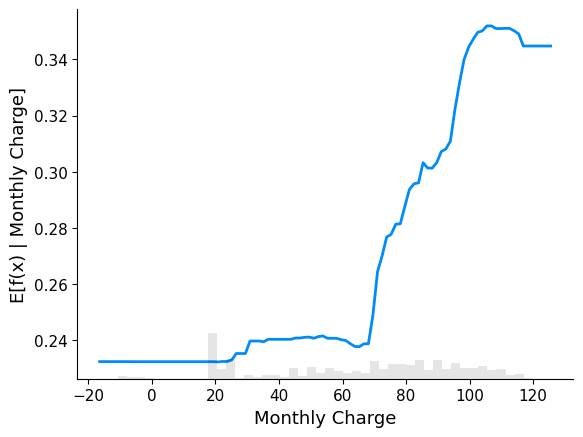

In [182]:
import shap
from catboost import Pool
pool_train = Pool(X_train_vanille, cat_features=cat_cols)

shap.plots.partial_dependence(
'Monthly Charge',
lambda X: catgbm_model3.predict_proba(Pool(X, cat_features=cat_cols))[:, 1],
X_train_vanille,
ice=False)

In [175]:
import pickle

with open('final_catboost_model29.12.2025.pkl', 'wb') as f:
	pickle.dump(catgbm_model3, f)

In [ ]:
with open('final_catboost_model29.12.2025.pkl', 'rb') as f:
	catgbm_model = pickle.load(f)

pred = catgbm_model.predict(X_test_vanille)
pred_probas = catgbm_model.predict_proba(X_test_vanille)

pd.DataFrame(pred).to_csv('predictions_by_catgbm.csv')
pd.DataFrame(pred_probas).to_csv('predictions_probas_by_catgbm.csv')